# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std

In [4]:
federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

# LeNet

In [5]:
import torch.nn as nn

class D_CNN(nn.Module):
    def __init__(self):
        super(D_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        return x
    
model = D_CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # TODO momentum is not supported at the moment

# 训练

In [6]:
criterion = nn.CrossEntropyLoss().to(device)

In [7]:
# 定义一个函数，用SVD对单通道矩阵进行压缩
def compress_channel(data, k):
    # 将data变量从torch.Tensor类型转换为numpy.ndarray类型
    data = data.numpy()
    # 创建一个空的numpy.ndarray变量，用来存放压缩后的图像
    output = np.zeros_like(data)
    # 用for循环来遍历data变量中的每个图像，并调用compress_channel函数来对每个图像进行压缩
    for i in range(len(data)):
        # 对单通道矩阵进行SVD分解
        channel = data[i, 0, :, :]
        U, S, V = np.linalg.svd(channel)
        # 取前k个奇异值和对应的左右奇异向量
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        V_k = V[:k, :]
        # 用前k个奇异值和奇异向量重构单通道矩阵
        channel_k = np.dot(U_k, np.dot(S_k, V_k))
        # 将重构后的矩阵元素值限制在0-255之间
        output[i, 0, :, :]  = np.clip(channel_k, 0, 255)
    # 将output变量从numpy.ndarray类型转换回torch.Tensor类型
    output = torch.from_numpy(output)
    return output

def compress_channel_split(data, k):
    # 将data变量从torch.Tensor类型转换为numpy.ndarray类型
    data = data.numpy()
    # 创建一个空的numpy.ndarray变量，用来存放压缩后的图像
    U_output = np.zeros_like(data)
    V_output = np.zeros_like(data)
    # 用for循环来遍历data变量中的每个图像，并调用compress_channel函数来对每个图像进行压缩
    for i in range(len(data)):
        # 对单通道矩阵进行SVD分解
        channel = data[i, 0, :, :]
        U, S, V = np.linalg.svd(channel)
        # 取前k个奇异值和对应的左右奇异向量
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        V_k = V[:k, :]
        # 用前k个奇异值和奇异向量重构单通道矩阵
        channel_k = np.dot(U_k, np.dot(S_k, V_k))
        # 将重构后的矩阵元素值限制在0-255之间
#         output[i, 0, :, :]  = np.clip(channel_k, 0, 255)
    # 将output变量从numpy.ndarray类型转换回torch.Tensor类型
    output = torch.from_numpy(output)
    return output

In [8]:
import numpy as np

loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        ##########################[SVD分解]###############################
        target = target.to(device) 
        data=compress_channel(data, 20)
        optimizer.zero_grad()
        output = model(data.to(device))
        ###########################[原始]##################################
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
        ################################################################
        n += target.shape[0]
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=loss.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
     100.*correct / n))

In [9]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [10]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 2.3021, Accuracy: 6566/60000 (11%)
Test set: Average loss: 2.3015, Accuracy: 1025/10000 (10%)
Train set: Average loss: 2.3007, Accuracy: 18298/60000 (30%)
Test set: Average loss: 2.3000, Accuracy: 1051/10000 (11%)
Train set: Average loss: 2.2991, Accuracy: 27728/60000 (46%)
Test set: Average loss: 2.2979, Accuracy: 1571/10000 (16%)
Train set: Average loss: 2.2967, Accuracy: 31820/60000 (53%)
Test set: Average loss: 2.2946, Accuracy: 2641/10000 (26%)
Train set: Average loss: 2.2926, Accuracy: 28094/60000 (47%)
Test set: Average loss: 2.2884, Accuracy: 2389/10000 (24%)
Train set: Average loss: 2.2826, Accuracy: 16384/60000 (27%)
Test set: Average loss: 2.2702, Accuracy: 985/10000 (10%)
Train set: Average loss: 2.2455, Accuracy: 14410/60000 (24%)
Test set: Average loss: 2.2089, Accuracy: 4126/10000 (41%)
Train set: Average loss: 2.0917, Accuracy: 30414/60000 (51%)
Test set: Average loss: 1.9813, Accuracy: 6047/10000 (60%)
Train set: Average loss: 1.8572, Accuracy:

# 结果保存

In [11]:
# save_name='LeNet-no-fed-cifar100'

In [12]:
# 保存模型的权重
# torch.save(model.state_dict(), "/home/raoxy/model/out/{}.pt".format(save_name))
# print("保存文件：","/home/raoxy/model/out/{}.pt".format(save_name))

In [13]:
# # 保存整个模型
# torch.save(model, "/home/raoxy/model/out/{}.h5".format(save_name))
# print("保存文件：","/home/raoxy/model/out/{}.h5".format(save_name))

# 分析

In [14]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [15]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("/home/raoxy/file/{}".format(save_name),index=False)
mpl.style.use('seaborn-white')

<IPython.core.display.Javascript object>


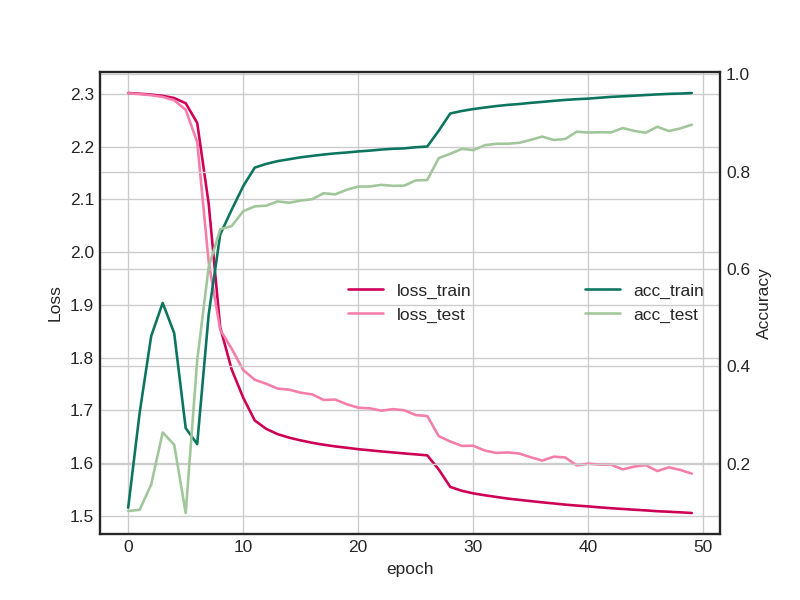

In [16]:
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()